In [67]:
import os 
import sys

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../RD-systems-and-test-benches/utils")
import model_fsolve as modf
import model_fsolve_v2 as modf2

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.constants as scc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import hx_hydraulic as hxhy
import from_excel as fe
import data_plots as dplt

import fluids as fds
from CoolProp.CoolProp import PropsSI

import openpyxl as opxl
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import os
import plotly.graph_objects as go

sys.path.append('../RD-systems-and-test-benches/')
import utils.data_processing as dp

from tqdm import tqdm

In [92]:
import repo_config as rconfig

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import matplotlib_inline

import scienceplots

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.style.use(['science'])

def to_percent(y, _):
    return f"{y * 100:.0f}\%"

# colors = ['olive', 'green', 'blue', 'orange', 'red', 'grey','yellow','bordeaux']
colors = ['olive','orange','blue','red','green','grey']
colors70 = [rconfig.get_hex_code(color, 70) for color in colors]
colors = [rconfig.get_hex_code(color, 100) for color in colors]
linestyles = ['-', '--',  (5, (10, 3)), '-.', (0, (1, 1)), (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5))]
markers = ['o', 's', 'd', 'X', 'v', '^', 'P', 'H']

In [3]:
Vdot_list = [0.01, 0.025, 0.05, 0.1, 0.5, 1., 1.5, 2., 3., 5.] 

p_op = 1e5
T_op = 25+273.15   

# SR_fp = r'G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\CFD\V4.5_1channel_SR'
SR_fp = r'D:\ANSYS Fluent Projects\Hydraulics\V4.5\V4.5_1channel\SimulationResults'

In [5]:
# Define your SSH and folder details here
hostname = '10.9.8.7'
port = 22
username = 'seagu'
password = 'Seagull_DS4'  # Use SSH key for better security if possible

ssh = dp.create_ssh_client(hostname, port, username, password)

In [84]:
Volume_channel = 8885.2644e-6 # mm^2
Ac = 5.5427e-6 # m2
L_channel = Volume_channel/Ac

L_Bsection = 600e-3

h = 0.002
w = 0.00281

Dh = 2*h*w/(h+w)

alpha_star = h/w

r_equivalent_tube = (Ac/math.pi)**(1/2)
D_equivalent_tube = 2 * r_equivalent_tube

In [9]:
sp_dict = {}
channelPL_dict ={}

for caoMeshName in tqdm(['V4.5_1chMid_M1', 'V4.5_1chMid_M2', 'V4.5_1chSide_M1', 'V4.5_1chSide_M2'], total=4):

    res = []

    for Vdot in Vdot_list:
        # print('Vdot', Vdot)

        folder_path_case = os.path.join(SR_fp, caoMeshName, 'parametric_laminar_try0', f'case_{str(Vdot)}Lh')

        # report_names = ['report_outlet_sp', 'report_inlet_sp', 'report_outlet_mdot']
        # for report_name in report_names:
        #     jg.change_report_file_path(tui, report_name, os.path.join(folder_path_case, f"{report_name}.out"))

        Vdot_m3s = Vdot * 1e-3 / 3600 # m3/s
        
        V = Vdot_m3s / Ac # m/s

        sp_df = dp.read_csv_ssh(ssh, os.path.join(folder_path_case, 'sp_report.csv'), sep=',')

        if 'chMid_M2' in caoMeshName:
            inlet_name = 'int_b_tube'
            outlet_name = 'int_h_tube'
        else:
            inlet_name = 'inlet'
            outlet_name = 'outlet'

        PL = sp_df.loc[sp_df['Component'] == inlet_name, 'sp'].values[0] - sp_df.loc[sp_df['Component'] == outlet_name, 'sp'].values[0]

        sp_dict[caoMeshName, Vdot] = sp_df

        res.append({'Vdot': Vdot, 'V': V, 'PL': PL})

    channelPL_dict[caoMeshName] = pd.DataFrame(res)
    print('--')

 25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

--


 50%|█████     | 2/4 [00:07<00:07,  3.59s/it]

--


 75%|███████▌  | 3/4 [00:10<00:03,  3.61s/it]

--


100%|██████████| 4/4 [00:14<00:00,  3.60s/it]

--


In [13]:
B_PL_list = []

for Vdot in Vdot_list:

    local_df = sp_dict['V4.5_1chMid_M1', Vdot]
    B_PL_list.append(local_df.loc[local_df['Component'] == 'ab', 'sp'].values[0] - local_df.loc[local_df['Component'] == 'bc', 'sp'].values[0])

In [90]:
sp_dict['V4.5_1chMid_M1', 0.1]

,Component,sp
0,ab,1.421948e+02
1,bc,8.606986e+01
2,cd,6.387319e+01
3,chmid_a:1,1.440386e+02
4,chmid_b:1,1.141327e+02
5,chmid_c:1,7.497150e+01
6,chmid_d:1,3.397010e+01
7,chmid_e:1,2.030929e+00
8,chmid_z:1,1.479190e+02
9,de,4.065661e+00


In [58]:
theo = []

for Vdot in Vdot_list:

    Vdot_m3s = Vdot * 1e-3 / 3600 # m3/s
    V = Vdot_m3s / Ac # m/s

    channel = hxhy.duct('rectangular', h = 0.002, w = 0.0028, L = L_Bsection) # kPa
    PL_guess = 1000 * channel.regular_PL(Vdot, fluid_dict= {'name':'MPG', 'glycol_rate' : 0.4}, p=p_op, T=T_op) # Pa

    theo.append(PL_guess)

In [57]:
darcy_weisbach_poiseuille = []

for Vdot in Vdot_list:

    Vdot_m3s = Vdot * 1e-3 / 3600 # m3/s
    V = Vdot_m3s / Ac # m/s

    rho = PropsSI('D', 'T', T_op, 'P', p_op, 'INCOMP::MPG[0.4]') # kg/m3
    mu = PropsSI('V', 'T', T_op, 'P', p_op, 'INCOMP::MPG[0.4]') # Pa.s
    Re = fds.Reynolds(V, D=Dh, rho=rho, mu=mu)

    Lambda = 64/Re

    darcy_weisbach_poiseuille.append(Lambda * (L_Bsection/Dh) * rho * (V**2/2))

In [87]:
dwp_equiv_tube = []

for Vdot in Vdot_list:

    Vdot_m3s = Vdot * 1e-3 / 3600 # m3/s
    V = Vdot_m3s / Ac # m/s

    rho = PropsSI('D', 'T', T_op, 'P', p_op, 'INCOMP::MPG[0.4]') # kg/m3
    mu = PropsSI('V', 'T', T_op, 'P', p_op, 'INCOMP::MPG[0.4]') # Pa.s
    Re = fds.Reynolds(V, D=D_equivalent_tube, rho=rho, mu=mu)

    Lambda = 64/Re

    dwp_equiv_tube.append(Lambda * (L_Bsection/D_equivalent_tube) * rho * (V**2/2))

In [54]:
shah_london_shih = []
tirunarayanan = []
natarajan = []

for Vdot in Vdot_list:

    Vdot_m3s = Vdot * 1e-3 / 3600 # m3/s
    V = Vdot_m3s / Ac # m/s

    rho = PropsSI('D', 'T', T_op, 'P', p_op, 'INCOMP::MPG[0.4]') # kg/m3
    mu = PropsSI('V', 'T', T_op, 'P', p_op, 'INCOMP::MPG[0.4]') # Pa.s
    Re = fds.Reynolds(V, D=Dh, rho=rho, mu=mu)

    f = ( 24 * (1 - 1.3553*alpha_star + 1.9467*alpha_star**2 - 1.7012*alpha_star**3 + 0.9564*alpha_star**4 - 0.2537*alpha_star**5) )/Re
    shah_london_shih.append((f*L_Bsection/(Dh/2)) * (rho) * V**2 )

    B_overline_divided_by_P = (1 + alpha_star*(2**(1/2) -1))/(4*(1+alpha_star))
    f = ( 14.227 + 1402.5*(B_overline_divided_by_P - ((2**(1/2))/8))**1.9 )/Re
    tirunarayanan.append( (f*L_Bsection/(Dh/2)) * (rho) * V**2 )

    f = ( 8.968*((1+alpha_star)/(alpha_star**(1/2)))**0.75 )/Re
    natarajan.append( (f*L_Bsection/(Dh/2)) * (rho) * V**2 )

0.3367236184809188
0.8418090462022969
1.6836180924045938
3.3672361848091876
16.836180924045937
33.672361848091874
50.50854277213781
67.34472369618375
101.01708554427562
168.3618092404594


In [150]:
error = ( np.array(shah_london_shih) - np.array(B_PL_list) ) / np.array(B_PL_list)

In [151]:
error

array([0.02418519, 0.02413616, 0.02404834, 0.02387037, 0.02244036,
       0.02070673, 0.01906872, 0.0175105 , 0.01462172, 0.00914201])

In [147]:
mae = mean_absolute_error(B_PL_list, shah_london_shih)

In [153]:
mae

10.723292729256176

In [152]:
mae/np.mean(B_PL_list)

0.01435613019412472

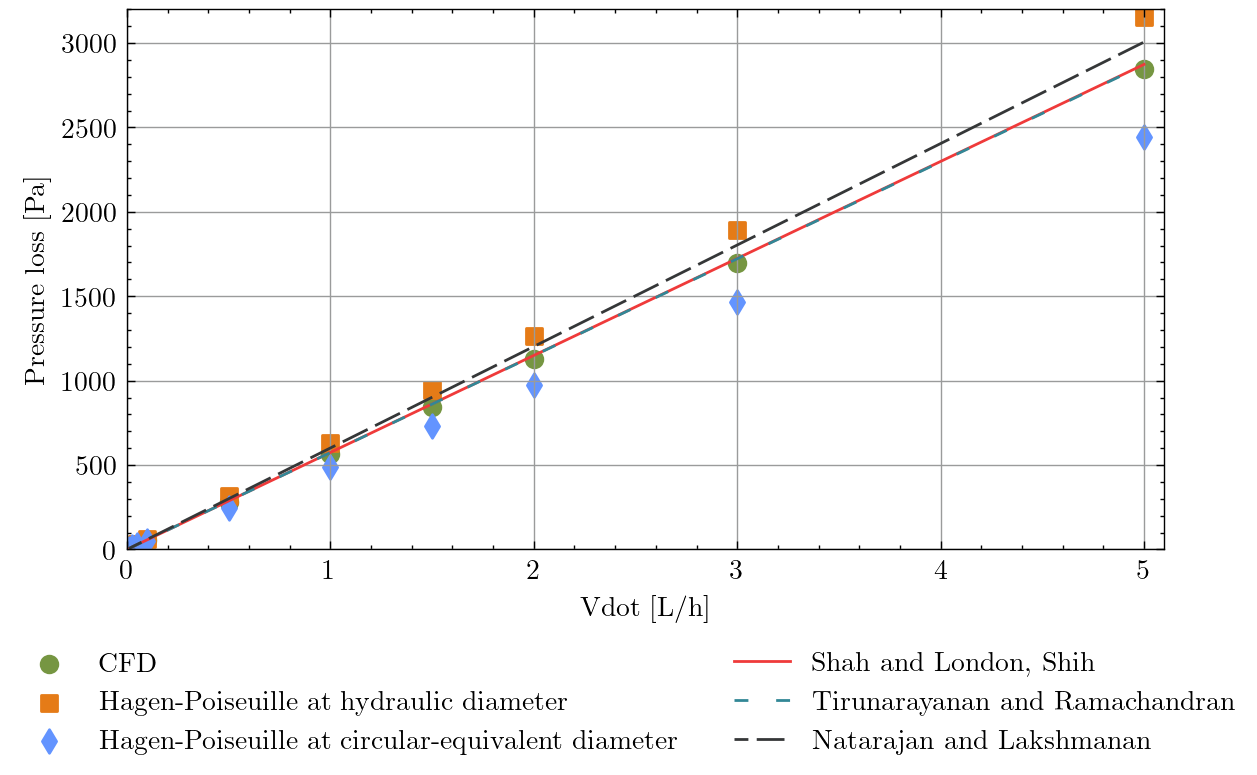

In [106]:
fig, ax1 = plt.subplots(figsize=(rconfig.wcol_in, rconfig.hfig(0.3, unit="in")))

ax1.scatter(Vdot_list, B_PL_list, label='CFD', marker = markers[0], color=colors[0])
ax1.scatter(Vdot_list, darcy_weisbach_poiseuille, label='Hagen-Poiseuille at hydraulic diameter', marker = markers[1], color=colors[1])
ax1.scatter(Vdot_list, dwp_equiv_tube, label='Hagen-Poiseuille at circular-equivalent diameter', marker = markers[2], color=colors[2])
# ax1scatter(Vdot_list, theo, label='theo')
ax1.plot(Vdot_list, shah_london_shih, label='Shah and London, Shih', linestyle= linestyles[0], color=colors[3])
ax1.plot(Vdot_list, tirunarayanan, label='Tirunarayanan and Ramachandran', linestyle = (0, (5, 10)), color=colors[4])
ax1.plot(Vdot_list, natarajan, label='Natarajan and Lakshmanan', linestyle= linestyles[2], color=colors[5])

ax1.grid(linewidth=0.5, color=rconfig.get_hex_code('grey', 70))

ax1.set_xlabel('Vdot [L/h]')
ax1.set_ylabel('Pressure loss [Pa]')

ax1.set_xlim(0,5.1)
ax1.set_ylim(0, 3200)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.), ncol=2, frameon=False,)

In [107]:
fig.savefig(r'G:\Mon Drive\GitHub\VDE_thesis\image\Chapter_PL\channel600mm.png', dpi=600)

In [108]:
V_array = (np.array(Vdot_list) * 1e-3 / 3600) / Ac

In [109]:
np.array([2,3,4,5])**2

array([ 4,  9, 16, 25])

In [116]:
len(y)

10

Slope: 11330.117659327627, Intercept: 0.0
0.9999757608692588


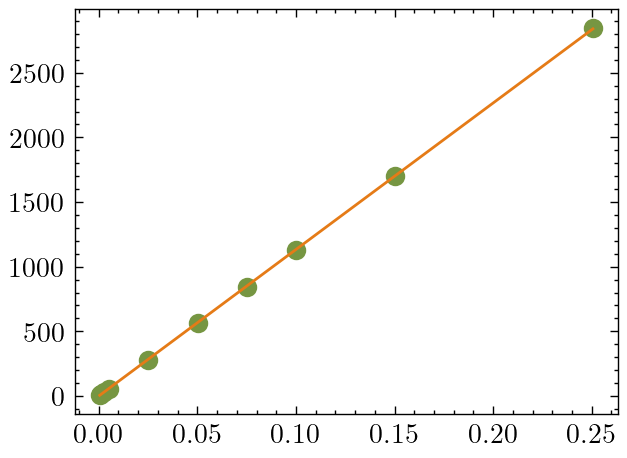

In [122]:
# Example data
X = (V_array).reshape(-1, 1)
y = np.array(B_PL_list)

# Create and fit the model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Get the coefficient (slope) and intercept
slope = model.coef_[0]
intercept = model.intercept_

print(f"Slope: {slope}, Intercept: {intercept}")

# r2 coefficient
r2 = r2_score(y, model.predict(X))
print(r2)

plt.scatter(X, y, color=colors[0])
plt.plot(X, model.predict(X), color=colors[1])

In [123]:
Cons = slope / L_Bsection

In [127]:
(L_channel/1000)

1.6030570660508416

In [139]:
channelPL_dict['V4.5_1chMid_M2']['PL_if_straight'] = Cons * (L_channel/1000) * channelPL_dict['V4.5_1chMid_M2']['V']

In [140]:
channelPL_dict['V4.5_1chMid_M2']

,Vdot,V,PL,PL_if_straight
0,0.010,0.000501,14.722501,15.170793
1,0.025,0.001253,36.806882,37.926982
2,0.050,0.002506,73.615880,75.853964
3,0.100,0.005012,147.240380,151.707929
4,0.500,0.025058,736.586220,758.539643
5,1.000,0.050116,1474.423500,1517.079286
6,1.500,0.075174,2214.298300,2275.618929
7,2.000,0.100232,2957.267100,3034.158572
8,3.000,0.150348,4455.789800,4551.237858
9,5.000,0.250580,7513.971600,7585.396429


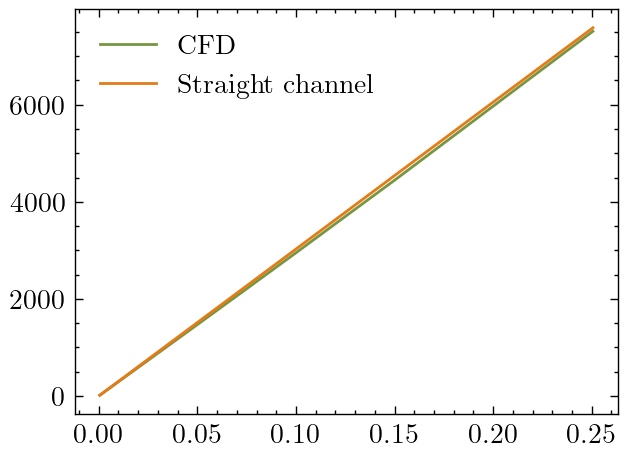

In [143]:
plt.plot(channelPL_dict['V4.5_1chMid_M1']['V'], channelPL_dict['V4.5_1chMid_M2']['PL'], color=colors[0], label='CFD')
plt.plot(channelPL_dict['V4.5_1chMid_M1']['V'], channelPL_dict['V4.5_1chMid_M2']['PL_if_straight'], color=colors[1], label='Straight channel')
plt.legend()

In [161]:
Vdot_list

[0.01, 0.025, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0]

In [160]:
((channelPL_dict['V4.5_1chMid_M1']['PL'] - channelPL_dict['V4.5_1chMid_M1']['PL_if_straight']) / channelPL_dict['V4.5_1chMid_M1']['PL_if_straight'])

0   -0.011318
1   -0.011256
2   -0.011140
3   -0.010907
4   -0.009014
5   -0.006546
6   -0.003897
7   -0.000988
8    0.005531
9    0.020369
dtype: float64

In [50]:
np.array(B_PL_list) / np.array(tirunarayanan)

array([3.90985504, 3.91004221, 3.91037754, 3.91105724, 3.91652736,
       3.9231794 , 3.92948539, 3.93550302, 3.94670799, 3.96813885])

In [ ]:
channelPL_dict['V4.5_1chMid_M1']

In [ ]:
channelPL_dict['V4.5_1chSide_M1']

In [ ]:
channelPL_dict['V4.5_1chSide_M2']

In [6]:
res = []

for Vdot in Vdot_list:

    Vdot_m3s = Vdot * 1e-3 / 3600 # m3/s
    Ac = 0.0000055427 # m2
    V = Vdot_m3s / Ac # m/s

    channel = hxhy.duct('rectangular', h = 0.002, w = 0.0028, L = 1.603) # kPa
    PL_guess = 1000 * channel.regular_PL(Vdot, fluid_dict= {'name':'MPG', 'glycol_rate' : 0.4}, p=p_op, T=T_op) # Pa

    res.append({'Vdot': Vdot, 'V' : V, 'PL': PL_guess})

channelPL_dict['theoretical'] = pd.DataFrame(res)

In [ ]:
for key, df in channelPL_dict.items():
    plt.plot(df['Vdot'], df['PL'], label=key)

plt.legend()

In [14]:
all_PL = pd.concat([df for key, df in channelPL_dict.items() if key != 'theoretical'])
all_PL.sort_values(by='Vdot', inplace=True)

In [ ]:
plt.scatter(all_PL['V'], all_PL['PL'])
plt.plot(X, y_pred, color='red')

In [ ]:
# Example data
X = all_PL['V'].values.reshape(-1, 1)  # Feature (independent variable)
y = all_PL['PL'].values  # Target (dependent variable)

# Create and fit the model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Get the coefficient (slope) and intercept
slope = model.coef_[0]
intercept = model.intercept_

print(f"Slope: {slope}, Intercept: {intercept}")

# Predict using the model
y_pred = model.predict(X)
# print(f"Predicted values: {y_pred}")

# Compute MAE, RMSE, and R²
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"MAE: {mae}")
print(f"MAE/mean: {round((mae/np.mean(y))*100,1)}%")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Predict using the model
y_pred = model.predict(X)

# Calculate the error (residuals)
error = y - y_pred

# Calculate absolute error
absolute_error = np.abs(error)

# Calculate percentage error as a percentage of the true y value
percentage_error = (y - y_pred)/y

# Compute statistics for error
error_stats = {
    "Error Mean": np.mean(error),
    "Error Min": np.min(error),
    "Error Max": np.max(error),
    "Error Std Dev": np.std(error)
}

# Compute statistics for absolute error
absolute_error_stats = {
    "Absolute Error Mean": np.mean(absolute_error),
    "Absolute Error Min": np.min(absolute_error),
    "Absolute Error Max": np.max(absolute_error),
    "Absolute Error Std Dev": np.std(absolute_error)
}

# Compute statistics for percentage error
percentage_error_stats = {
    "Percentage Error Mean": np.mean(percentage_error),
    "Percentage Error Min": np.min(percentage_error),
    "Percentage Error Max": np.max(percentage_error),
    "Percentage Error Std Dev": np.std(percentage_error)
}

# Display the results
print("Error Statistics:", error_stats)
print("Absolute Error Statistics:", absolute_error_stats)
print("Percentage Error Statistics:", percentage_error_stats)

In [ ]:
PL = Slope * V

In [47]:
channelPL_dict['V4.5_1chMid_M2']['PL_M1'] = channelPL_dict['V4.5_1chMid_M1']['PL']

In [50]:
channelPL_dict['V4.5_1chMid_M2']['relative difference'] = (channelPL_dict['V4.5_1chMid_M2']['PL'] - channelPL_dict['V4.5_1chMid_M2']['PL_M1']) / channelPL_dict['V4.5_1chMid_M2']['PL_M1']

In [ ]:
channelPL_dict['V4.5_1chMid_M2']

In [32]:
# https://www.youtube.com/watch?v=I3GUOCTweCQ

density = 1029.39624 # kg/m3
viscosity = 0.0035801923 # kg/ms
thickness = 0.010 # m

a = 0

inertial_resistance = a*2 / (density * thickness) # C2 = 0 if linear (laminar) inertial resistance
viscous_resistance = slope / (viscosity * thickness) # viscous resistance

In [ ]:
viscous_resistance